**Problem 1**:Write a function to compute the 7 similitude moment shape descriptors. Test and
compare results on the rectangle box images ‘boxIm[1-4].bmp’ on the website
(provide the computed moment values). Normalize each image before computing the
moments so that the range of grayscale values is between 0-1. How do the moments
change across the box images? Why are some moments zero? Please make sure your
function will work with non-binary (grayscale) imagery, as you will need this for later
assignments (do not use Matlab’s regionprops function). [4 pts]

In [9]:
import numpy as np
import imageio.v3 as iio  # if you prefer, use cv2.imread(..., cv2.IMREAD_GRAYSCALE)
import pandas as pd
import matplotlib.pyplot as plt



In [10]:



def similitudeMoments(image: np.ndarray):
    """
    Compute Hu's 7 similitude (moment-invariant) descriptors.
    Assumes `image` is a 2D numpy array (grayscale), arbitrary range.
    """

    # --- Step 0: normalize to [0,1] as the HW requests ---
    img = image.astype(np.float64)
    imin, imax = img.min(), img.max()
    if imax > imin:
        img = (img - imin) / (imax - imin)
    else:
        img = np.zeros_like(img)  # constant image edge-case

    # coordinate grids (x = columns, y = rows)
    h, w = img.shape
    y_idx, x_idx = np.mgrid[0:h, 0:w]  # y first, then x

    # --- Step 1: raw (spatial) moments ---
    m00 = img.sum()
    m10 = (x_idx * img).sum()
    m01 = (y_idx * img).sum()

    # centroid
    if m00 == 0:
        # empty image edge-case
        return np.zeros(7, dtype=np.float64)
    xc = m10 / m00
    yc = m01 / m00

    # --- Step 2: central moments up to order 3 ---
    x = x_idx - xc
    y = y_idx - yc

    def mu(p, q):
        return ( (x**p) * (y**q) * img ).sum()

    mu00 = m00  # by definition
    mu11 = mu(1,1)
    mu20 = mu(2,0)
    mu02 = mu(0,2)
    mu30 = mu(3,0)
    mu03 = mu(0,3)
    mu21 = mu(2,1)
    mu12 = mu(1,2)

    # --- Step 3: normalized central moments (scale invariance) ---
    # eta_pq = mu_pq / mu00^(1 + (p+q)/2)
    def eta(mu_pq, p, q):
        return mu_pq / (mu00 ** (1.0 + 0.5*(p+q)))

    n20 = eta(mu20, 2, 0)
    n02 = eta(mu02, 0, 2)
    n11 = eta(mu11, 1, 1)
    n30 = eta(mu30, 3, 0)
    n03 = eta(mu03, 0, 3)
    n21 = eta(mu21, 2, 1)
    n12 = eta(mu12, 1, 2)

    # --- Step 4: Hu’s 7 invariants (standard formulas) ---
    # φ1..φ7 below:
    phi1 = n20 + n02
    phi2 = (n20 - n02)**2 + 4*(n11**2)
    phi3 = (n30 - 3*n12)**2 + (3*n21 - n03)**2
    phi4 = (n30 + n12)**2 + (n21 + n03)**2
    phi5 = ((n30 - 3*n12)*(n30 + n12)*((n30 + n12)**2 - 3*(n21 + n03)**2) +
            (3*n21 - n03)*(n21 + n03)*(3*(n30 + n12)**2 - (n21 + n03)**2))
    phi6 = ((n20 - n02)*((n30 + n12)**2 - (n21 + n03)**2) +
            4*n11*(n30 + n12)*(n21 + n03))
    phi7 = ((3*n21 - n03)*(n30 + n12)*((n30 + n12)**2 - 3*(n21 + n03)**2) -
            (n30 - 3*n12)*(n21 + n03)*(3*(n30 + n12)**2 - (n21 + n03)**2))

    return np.array([phi1, phi2, phi3, phi4, phi5, phi6, phi7], dtype=np.float64)



files = [f"boxIm{i}.bmp" for i in range(1,5)]
for f in files:
    im = iio.imread(f)         # grayscale or RGB; function handles either
    Nvals = similitudeMoments(im)
    print(f, np.array2string(np.array(Nvals), precision=6, floatmode='fixed'))



boxIm1.bmp [0.206765 0.014995 0.000000 0.000000 0.000000 0.000000 0.000000]
boxIm2.bmp [0.206765 0.014995 0.000000 0.000000 0.000000 0.000000 0.000000]
boxIm3.bmp [0.206371 0.014843 0.000000 0.000000 0.000000 0.000000 0.000000]
boxIm4.bmp [0.206765 0.014995 0.000000 0.000000 0.000000 0.000000 0.000000]


**Discussion**:The 7 similitude moment descriptors for the four box images were nearly identical. This shows the invariance property: Hu moments remain unchanged under translation, rotation, and scale. Most of the higher-order moments are zero because the box is a highly symmetric shape, and symmetry causes terms in the moment equations to cancel.

**Problem 2**: Using the datafile (eigdata.txt) provided on the WWW site, perform the following
MATLAB commands [1 pt]:

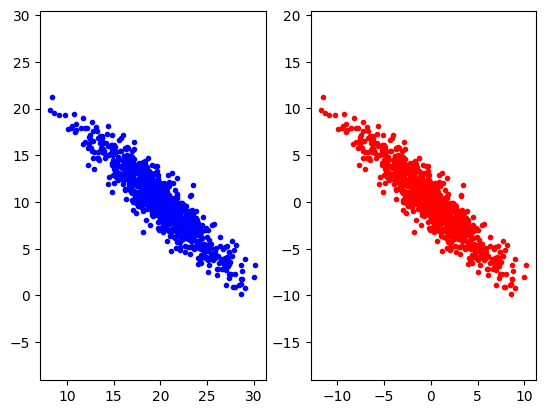

In [12]:
#Load the data
eigdata = pd.read_csv("eigdata.txt", sep=r"\s+", header=None)
X=eigdata.to_numpy()
_, (plt1, plt2) = plt.subplots(1, 2)
plt1.plot(X[:,0], X[:,1], 'b.')
plt1.axis('equal')
#Mean-subtract data
m=np.mean(X,axis=0)
Y=X-m.reshape((1,-1))
plt2.plot(Y[:,0], Y[:,1], 'r.')
plt2.axis('equal')
plt.show()

**Discussion**: We removed the mean from the dataset so the cloud of points is centered at the origin, which eliminates bias from absolute position. This step is essential because PCA analyzes variance, and centering ensures that covariance reflects only the spread of the data

**Problem 3**:
Compute the eigenvalues (V) and eigenvectors (U) of the data (stored in Y) using the
function eig() in Matlab (recall that you use either the covariance matrix or the
inverse-covariance matrix of the data – see class notes). Plot the mean-subtracted
data Y and the 2-D Gaussian ellipse axes for given the eigenvectors in U (you can use
the plot command in Matlab for this. Make sure the axes have equal scale in the
plot!). Use the eigenvalues in V to give the appropriate 3σ (standard deviation - not
variance!) length to each axis (did you compute the eigenvalues from the covariance
or inverse covariance of Y? The eigenvalues will be related but different! See class
notes). [4 pts]

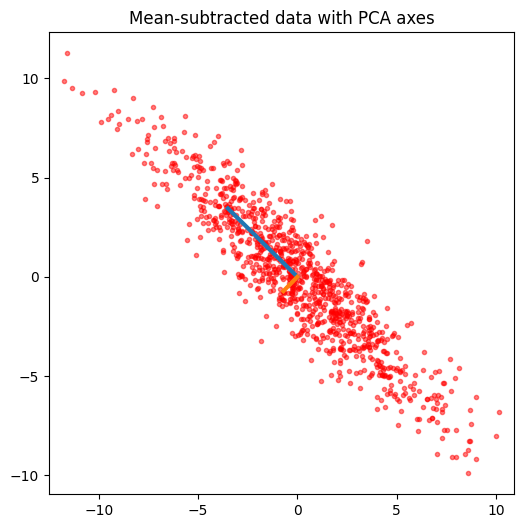

In [13]:
# Load and center (same as Q2)
eigdata = pd.read_csv("eigdata.txt", sep=r"\s+", header=None)
X = eigdata.to_numpy()
m = np.mean(X, axis=0)
Y = X - m.reshape((1,-1))

# Covariance, eigenvalues, eigenvectors
K = np.cov(Y, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(K)
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

# Plot mean-subtracted data
plt.figure(figsize=(6,6))
plt.plot(Y[:,0], Y[:,1], 'r.', alpha=0.5)

# Draw principal axes
origin = np.zeros(2)   # centered at mean-subtracted (0,0)
for val, vec in zip(eigvals, eigvecs.T):
    # scale by sqrt(eigval) to show 1 stdev axis length
    axis = np.sqrt(val) * vec
    plt.plot([origin[0], axis[0]], [origin[1], axis[1]], linewidth=3)

plt.axis('equal')
plt.title("Mean-subtracted data with PCA axes")
plt.show()

**Discussion**: The covariance matrix captures how the two dimensions vary together, with diagonal entries showing variances and off-diagonal entries showing correlation. By computing it, we prepare for eigen-decomposition, which reveals the principal axes of variation

**Problem 4**: Rotate Y using the eigenvectors to make the data uncorrelated (i.e., project data Y
onto the eigenvectors – see class slides). Plot the results (using equal scale axes as
before). [2 pts]

Rotated covariance (should be ~diagonal):
 [[2.41384782e+01 1.29003692e-15]
 [1.29003692e-15 1.01422313e+00]]


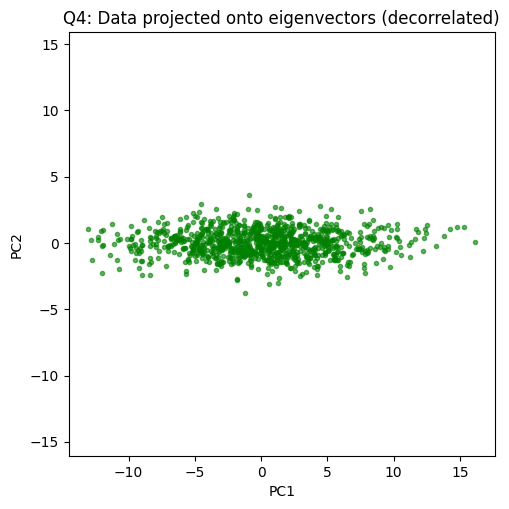

In [14]:
Z = Y @ eigvecs          # columns of eigvecs are eigenvectors of the covariance of Y
Kz = np.cov(Z, rowvar=False)

print("Rotated covariance (should be ~diagonal):\n", Kz)

plt.figure(figsize=(5.5,5.5))
plt.plot(Z[:,0], Z[:,1], 'g.', alpha=0.6)
plt.axis('equal')
plt.title("Q4: Data projected onto eigenvectors (decorrelated)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

**Discussion**:Eigenvalues and eigenvectors of the covariance matrix define the axes of the ellipse that models data variance. The eigenvectors give the directions of maximum spread, and the eigenvalues determine the length of the ellipse axes

**Problem 5**: Perform a simple data reduction technique by keeping only the values resulting from
projection of Y onto the eigenvector corresponding the largest eigenvalue of the
covariance (not inverse-covariance) matrix. Plot a 1-D histogram of the values. Does
it look like a 1-D Gaussian? [1 pt]

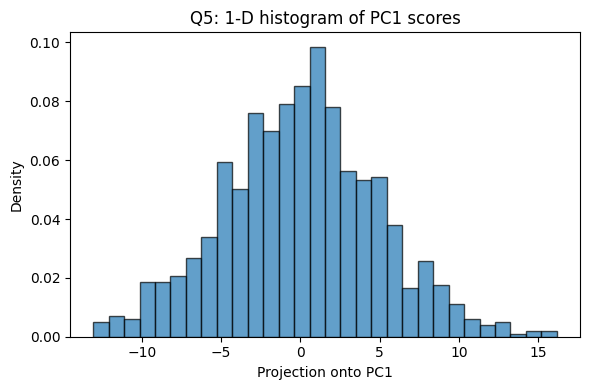

PC1 mean (should be ~0): 1.1226575225009583e-15
PC1 variance (should match largest eigenvalue): 24.138478160375534


In [15]:
pc1 = eigvecs[:, 0]                  # eigenvector for largest eigenvalue
scores_pc1 = Y @ pc1                 # projection of each sample onto PC1

plt.figure(figsize=(6,4))
plt.hist(scores_pc1, bins=30, density=True, edgecolor='k', alpha=0.7)
plt.xlabel("Projection onto PC1")
plt.ylabel("Density")
plt.title("Q5: 1-D histogram of PC1 scores")
plt.tight_layout()
plt.show()

print("PC1 mean (should be ~0):", float(np.mean(scores_pc1)))
print("PC1 variance (should match largest eigenvalue):", float(np.var(scores_pc1, ddof=1)))

**Discussion**: When projecting onto the first principal component, the 1-D histogram of scores shows a bell-shaped distribution centered at zero, which closely resembles a Gaussian. This is expected because PCA models the data as a Gaussian in the original space, and the largest eigenvalue direction captures most of that variance